## HW7: Teach me, senpai
### Цель:
Ваша задача - научить робота разумному, доброму и вечному, используя всю мощь обучения с подкреплением.


### Описание/Пошаговая инструкция выполнения домашнего задания:
* Возьмите среду Taxi из фреймворка gym: https://gym.openai.com/envs/.
* Определите и опишите какие у этой среды есть состояния и награды, а также какие действия можно совершать.
* Реализуйте один из алгоритмов поиска оптимальной стратегии: Value Iteration, Policy Iteration, Monte Carlo, SARSA, Q-learning.
* Получив оптимальную стратегию сыграйте 10 000 эпизодов и выведите оценку этой стратегии в виде средней награды за все игры и/или количество побед.
* Визуализируйте один эпизод игры с оптимальной стратегией.

### Библиотеки и константы

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import math
import numpy as np
from IPython.display import clear_output
import pandas as pd
from time import sleep

### Описание среды





### Библиотеки константы

In [2]:
env = gym.make("Taxi-v3", render_mode="rgb_array")

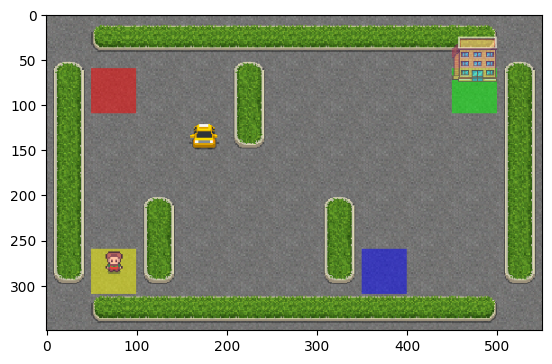

In [3]:
env.reset()
plt.imshow(env.render())

Среда Taxi представляет собой поле, в котором, есть такси(агент), пассажир, точки спауна пассажира, и точки куда нужно пассажира доставить.  
Задача агента - подобрать пассажира в одной из 4-х предопределённых локаций (R, G, B, Y) и доставить его в нужное место назначения (также R, G, B, Y).  


In [4]:
print("Количество действий:", env.action_space.n)

Количество действий: 6


В среде 6 дискретных действий:
* 0: Вниз
* 1: Вверх
* 2: Вправо
* 3: Влево
* 4: Подобрать пассажира
* 5: Высадить пассажира

Награды предусмотренные в среде:
* -1 за каждый шаг.
* -10 за неправильную высадку пассажира.
* +20 за успешную доставку.

In [5]:
print("Количество состояний:", env.observation_space.n)

Количество состояний: 500


In [6]:
env.reset()[0]

1

Состояние (state) — это число, которое можно декодировать в:
* Позицию такси (row, col).
* Местоположение пассажира (в такси или одна из 4 точек: R, G, B, Y).
* Пункт назначения пассажира (R, G, B, Y).

Попробуем проделать декодирование.

In [7]:
def decode_state(state):
    taxi_row = state // 100
    taxi_col = (state % 100) // 20
    passenger_loc = (state % 20) // 4
    destination = state % 4
    return taxi_row, taxi_col, passenger_loc, destination

taxi_row, taxi_col, passenger_loc, destination = decode_state(env.reset()[0])
print(f"Такси: ({taxi_row}, {taxi_col}), Пассажир: {passenger_loc}, Назначение: {destination}")

Такси: (2, 3), Пассажир: 2, Назначение: 0


Ну вроде сходится с картинкой среды выше.  
* Пассажир в клетке 0 - R.
* Такси в клетке (4,1)
* Назначение в клетке 3 - B.

### Обучение модели
Используем алгоритм Q-Learning для обучения нашего агента.

In [8]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        # print(state)
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value


    def get_value(self, state):
        """
        Estimation of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Q-values can be negative!
        """
        possible_actions = self.get_legal_actions(state)
        if len(possible_actions) == 0:
            return 0.0
        q_values = [self.get_qvalue(state, _a) for _a in possible_actions]
        value = max(q_values)
        return value

    def update(self, state, action, reward, next_state):
        """
        Q-Value update:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """
        gamma = self.discount
        learning_rate = self.alpha
        q = self.get_qvalue(state, action)
        v = self.get_value(next_state)
        new_value = (1 - learning_rate) * q + learning_rate * (reward + gamma * v)
        self.set_qvalue(state, action, new_value)

    def get_best_action(self, state):
        """
        The best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        q_values = [self.get_qvalue(state, _a) for _a in possible_actions]
        best_ind = np.argmax(q_values)
        best_action = possible_actions[best_ind]

        return best_action

    def get_action(self, state):
        """
        The action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        chosen_action = None
        if random.random() > epsilon:
          chosen_action = self.get_best_action(state)
        else:
          chosen_action = random.choice(possible_actions)

        return chosen_action

In [9]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)
        next_s, r, done, _, _ = env.step(a)

        # train (update) agent for state s
        # To-Do
        agent.update(s, a, r, next_s)
        s = next_s
        total_reward += r
        if done:
            break
    return total_reward

In [10]:
n_actions = env.action_space.n
agent_ql = QLearningAgent(alpha=0.05, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

QLEARNING mean reward = -4.69


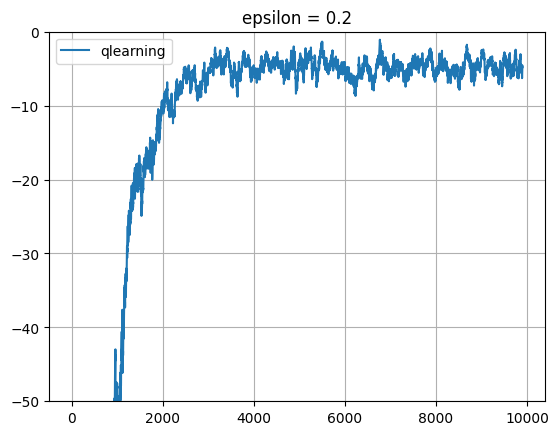

In [11]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_ql = []

for i in range(10000):
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-50, 0)
        plt.show()

In [12]:
max(rewards_ql)

15.0

Я заметил, что максимальная награда, которую можно достичь это 15. Вероятно, что это ситуация, когда такси спавнится в клетке рядом с пассажиром. Пассажир находится в клете Y, точка назначения в клетке R. Тогда у нас награда -5 за 5 шагов, и +20 за доставку.  
Но сомнительно.  

In [13]:
def play(env, agent, t_max=10**4):
    total_reward = 0.0
    t1 = 0
    for t in range(t_max):
        done = False
        s, _ = env.reset()
        while not done:
          # get agent to pick action given state s.
          if type(s) == int:
            action = agent_ql.get_best_action(s)
          else:
            action = agent_ql.get_best_action(s[0])
          s, r, done, _, _ = env.step(action)

          total_reward += r
        t1=t

    print('Средняя награда:', total_reward/t_max)
    return t1

In [14]:
t1 = play(env, agent_ql, 10000)

Средняя награда: 7.85


С найденной оптимальной стратегией средняя награда оказалась 7.85.  

Визуализируем стратегию на одном эпизоде. Не знаю как сделать анимацию, поэтому вывел каждй шаг в отдельную картинку. Что бы была псевдоанимацию нужно раскоментировать строку `# clear_output(wait=True)`.

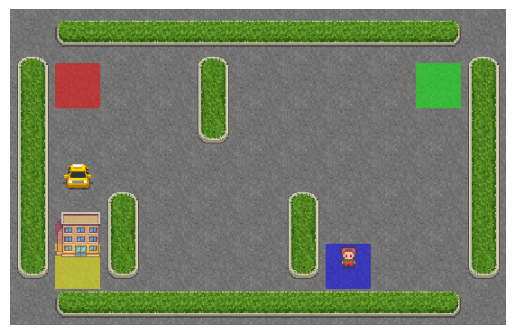


Число шагов: 1
Действие: 0
Награда: -1
Число штрафов: 0
Сумма наград: -1


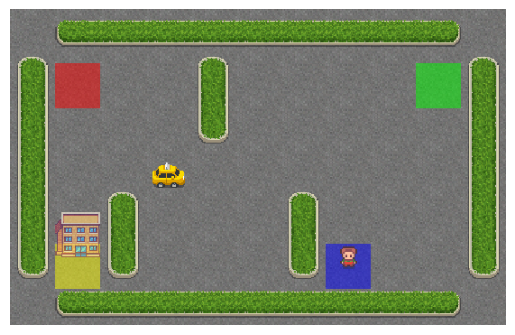


Число шагов: 2
Действие: 2
Награда: -1
Число штрафов: 0
Сумма наград: -2


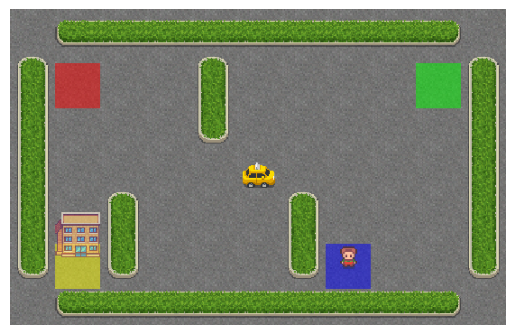


Число шагов: 3
Действие: 2
Награда: -1
Число штрафов: 0
Сумма наград: -3


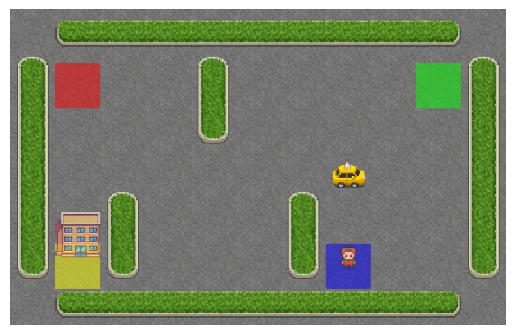


Число шагов: 4
Действие: 2
Награда: -1
Число штрафов: 0
Сумма наград: -4


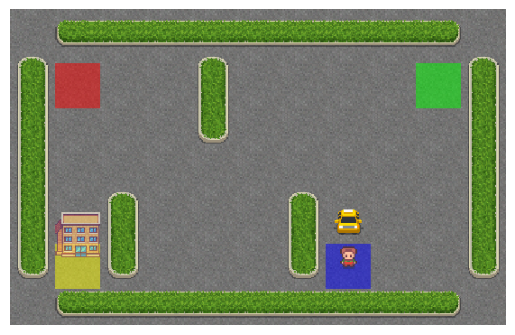


Число шагов: 5
Действие: 0
Награда: -1
Число штрафов: 0
Сумма наград: -5


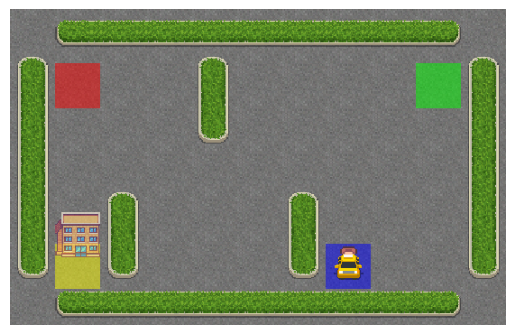


Число шагов: 6
Действие: 0
Награда: -1
Число штрафов: 0
Сумма наград: -6


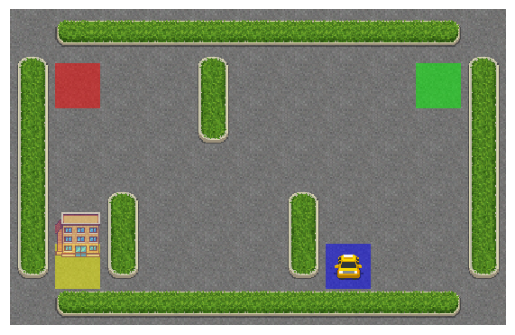


Число шагов: 7
Действие: 4
Награда: -1
Число штрафов: 0
Сумма наград: -7


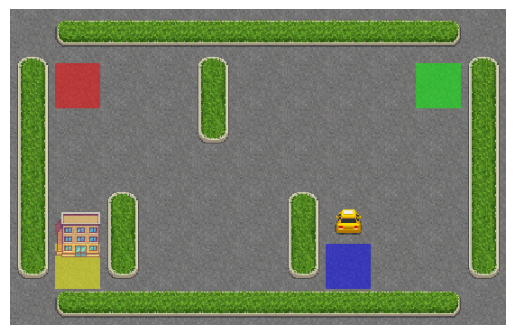


Число шагов: 8
Действие: 1
Награда: -1
Число штрафов: 0
Сумма наград: -8


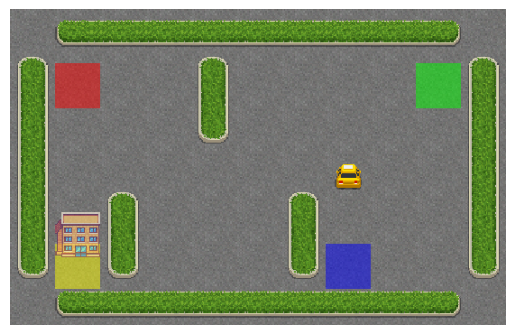


Число шагов: 9
Действие: 1
Награда: -1
Число штрафов: 0
Сумма наград: -9


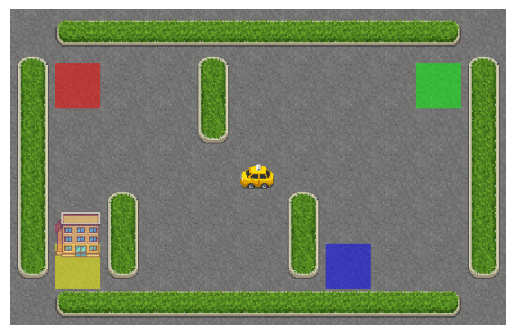


Число шагов: 10
Действие: 3
Награда: -1
Число штрафов: 0
Сумма наград: -10


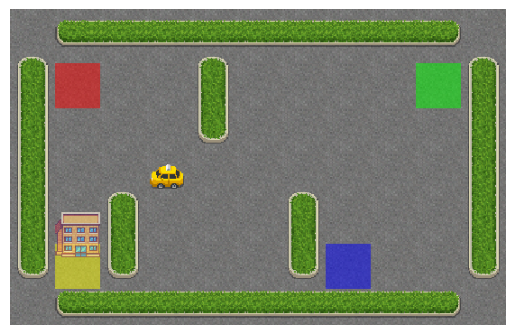


Число шагов: 11
Действие: 3
Награда: -1
Число штрафов: 0
Сумма наград: -11


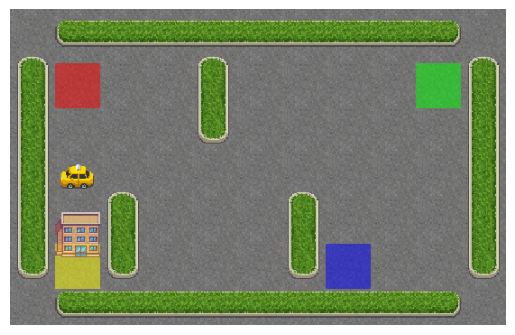


Число шагов: 12
Действие: 3
Награда: -1
Число штрафов: 0
Сумма наград: -12


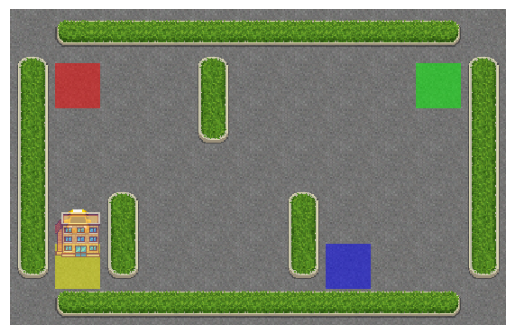


Число шагов: 13
Действие: 0
Награда: -1
Число штрафов: 0
Сумма наград: -13


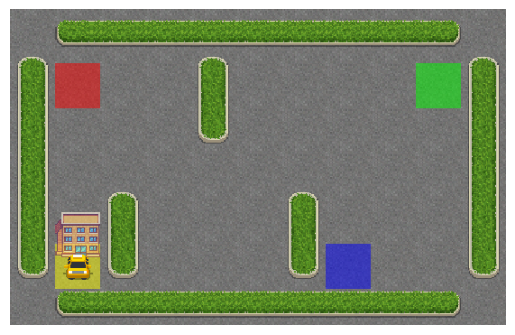


Число шагов: 14
Действие: 0
Награда: -1
Число штрафов: 0
Сумма наград: -14


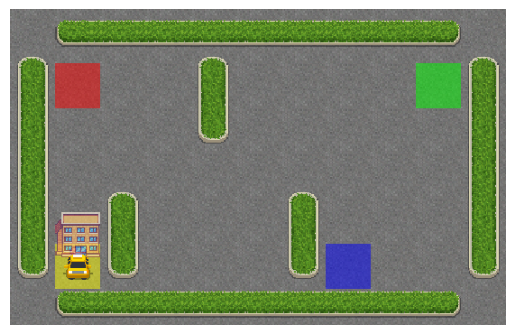


Число шагов: 15
Действие: 5
Награда: 20
Число штрафов: 0
Сумма наград: 6


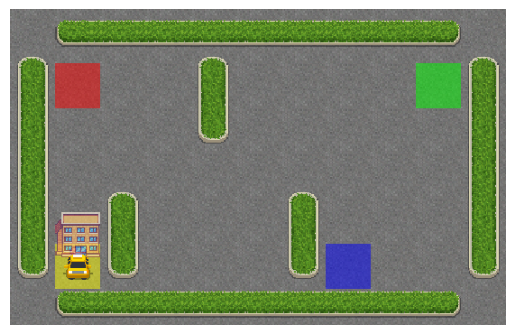

In [15]:
state = env.reset()
img = plt.imshow(env.render())
score, done, epochs, penalties = 0, False, 0, 0

# Визуализация работы агента
# Выбор оптимальных действий на основе изученных значений Q-таблицы
while not done:
    #action = np.argmax(q_table[state])
    if type(state) == int:
      action = agent_ql.get_best_action(state)
    else:
      action = agent_ql.get_best_action(state[0])
    state, reward, done, _, info = env.step(action)
    score += reward

    if reward == -10:
        penalties += 1

    epochs += 1

    img.set_data(env.render())
    plt.axis("off")
    display(plt.gcf())

    print('\n' + 'Число шагов:', epochs)
    print('Действие:', action)
    print('Награда:', reward)
    print('Число штрафов:', penalties)
    print('Сумма наград:', score)
    # clear_output(wait=True)
    #sleep(.5)
    sleep(0.5)

Красота. Человек доставлен по назначению.

### Вывод
Был реализован алгоритм Q-Learning для нахождения оптимальной стратегии в среде Taxi-v3. Средняя награда на найденной оптимальной стратегии оказалась 7.85.  